In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

# Loading the data

In [3]:
data = pd.read_csv('dataset/iris.data', header=None)
data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data['class'] = data['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data.tail()

,sepal_length,sepal_width,petal_length,petal_width,class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [5]:
data_np = data.to_numpy()
training, test = data_np[:30, :], data_np[30:50, :]
training, test = np.append(training, data_np[50:80, :], axis=0), np.append(test, data_np[80:100, :], axis=0)
training, test = np.append(training, data_np[100:130, :], axis=0), np.append(test, data_np[130:, :], axis=0)
training.shape, test.shape

((90, 5), (60, 5))

In [6]:
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train[:3], y_train[:3], X_test[:3], y_test[:3]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]]),
 array([0., 0., 0.]),
 array([[4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1]]),
 array([0., 0., 0.]))

Add a column of one to the dataset

In [7]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 5.1, 3.5, 1.4, 0.2],
        [1. , 4.9, 3. , 1.4, 0.2],
        [1. , 4.7, 3.2, 1.3, 0.2]]),
 array([[1. , 4.8, 3.1, 1.6, 0.2],
        [1. , 5.4, 3.4, 1.5, 0.4],
        [1. , 5.2, 4.1, 1.5, 0.1]]))

# MSE
Mean square function for (19) in compendium
$$
    MSE = \frac{1}{2} \sum_{k = 1}^N (g_k - t_k)^T (g_k - t_k)
$$

In [8]:
def mse(g_k, t_k):
    """
    Mean squared error
    :param g_k: predicted value
    :param t_k: target value
    :return: mean squared error
    """
    return np.matmul((g_k - t_k).T, (g_k - t_k)) / 2

The gradient is given as
$$
\nabla_{g_k} MSE = g_k - t_k
$$

In equation (22) from the compendium, following gradient for MSE is given with respect to weights
$$
\nabla_W MSE = \sum_{k=1}^N  [(g_k - t_k) \cdot g_k \cdot (1 - g_k)] x_k^T
$$

where $\cdot$ is elementwise multiplication 

In [9]:
def mse_grad_w(g_k, t_k, x_k):
    """
    Calculate the gradient of MSE
    :param g_k: predicted value
    :param t_k: target value
    :param x_k: input data
    :return: gradient of MSE
    """
    elementwise = np.multiply(
            g_k - t_k, 
            np.multiply(g_k, (1 - g_k))
        )
    return np.multiply(
        elementwise,
        x_k.T
    )

# Sigmoid function
The sigmoid function is used as an activation function
$$
    g_k = \frac{1}{1+e^{-Wx_k}}
$$

In [10]:
def sigmoid(weights, x_k):
    """
    sigmoid function
    :param weights: weights
    :param x_k: input data
    :return: sigmoid value
    """
    return 1 / (1 + np.exp(-np.matmul( weights, x_k)))

For training the weights can be updated using
$$
W(m) = W(m - 1) - \alpha \nabla_W MSE
$$

In [11]:
class LinearClassifier:
    def __init__(self, weight_dimention, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = np.random.rand(1, weight_dimention)
        self.historic_mse = []

    def train(self, X, y):
        for _ in range(self.n_iters):
            grad_mse_value = 0
            mse_value = 0

            for i in range(X.shape[0]):
                g_k = sigmoid(self.weights, X[i].T)
                mse_value += mse(g_k, y[i])
                grad_mse_value += mse_grad_w(g_k, y[i], X[i].T)
            
            self.historic_mse.append(mse_value)
            self.weights -= self.learning_rate * grad_mse_value

    def predict(self, X):
        output = []
        for i in range(X.shape[0]):
            output.append(np.round_(sigmoid(self.weights, X[i].T)))
        return np.array(output)

    def test(self, X, y):
        output = self.predict(X)
        return np.mean(output == y)

In [12]:
def multi_class_linear_classifier(n_iters=1000, learning_rate=0.01):
    numeric_to_setosa = np.vectorize(lambda val: 1 if val == 0 else 0)
    y_train_class_setosa = numeric_to_setosa(y_train)

    numeric_to_virginica = np.vectorize(lambda val: 1 if val == 2 else 0)
    y_train_class_virginica = numeric_to_virginica(y_train)

    classifier_setosa = LinearClassifier(X_train.shape[1], learning_rate, n_iters)
    classifier_setosa.train(X_train, y_train_class_setosa)
    plt.plot(classifier_setosa.historic_mse, label="Setosa")

    classifier_viriginica = LinearClassifier(X_train.shape[1], learning_rate, n_iters)
    classifier_viriginica.train(X_train, y_train_class_virginica)
    plt.plot(classifier_viriginica.historic_mse, label="Virginica")
    plt.legend(['MSE for Iris Setosa', 'MSE for Iris Virginica'], loc="upper right")
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.show()
    return classifier_setosa, classifier_viriginica


In [13]:
def multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X):
    output = []
    setosa_pred = classifier_setosa.predict(X)
    viriginica_pred = classifier_viriginica.predict(X)
    for i in range(X.shape[0]):
        if viriginica_pred[i] == 1:
            output.append(2)
        elif setosa_pred[i] == 1:
            output.append(0)
        else:
            output.append(1)

       
    return np.array(output)

In [14]:
def multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X, y):
    predicted_value = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X)
    return np.mean(predicted_value == y)

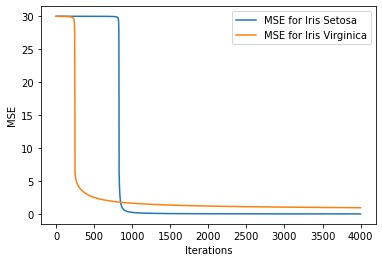

In [15]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [16]:
classifier_setosa.test(X_test, y_test)

0.3333333333333333

In [17]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9833333333333333

In [18]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)

In [19]:
def confusion_matrix(y_test, pred):
    """
    Calculate confusion matrix
    :param y_test: target value
    :param pred: predicted value
    :return: confusion matrix
    """
    y_actu = pd.Series(y_test, name='Actual')
    y_pred = pd.Series(pred, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    print(df_confusion)

In [20]:
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  19   1
2.0         0   0  20


# Task 1c

In [21]:

training, test = data_np[20:50, :], data_np[:20, :]
training, test = np.append(training, data_np[70:100, :], axis=0), np.append(test, data_np[50:70, :], axis=0)
training, test = np.append(training, data_np[120:, :], axis=0), np.append(test, data_np[100:120, :], axis=0)
training.shape, test.shape

((90, 5), (60, 5))

In [22]:
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train[:3], y_train[:3], X_test[:3], y_test[:3]


(array([[5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2]]),
 array([0., 0., 0.]),
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]]),
 array([0., 0., 0.]))

In [23]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 5.4, 3.4, 1.7, 0.2],
        [1. , 5.1, 3.7, 1.5, 0.4],
        [1. , 4.6, 3.6, 1. , 0.2]]),
 array([[1. , 5.1, 3.5, 1.4, 0.2],
        [1. , 4.9, 3. , 1.4, 0.2],
        [1. , 4.7, 3.2, 1.3, 0.2]]))

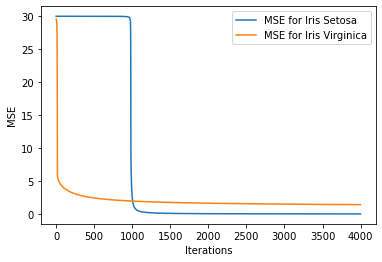

In [24]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [25]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9833333333333333

In [26]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  19   1
2.0         0   0  20


# Task 2a

Drops the sepal_width column

In [27]:
data = pd.read_csv('dataset/iris.data', header=None)
data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data['class'] = data['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data.drop("sepal_width", axis=1, inplace=True)
data.head()

,sepal_length,petal_length,petal_width,class
0,5.1,1.4,0.2,0
1,4.9,1.4,0.2,0
2,4.7,1.3,0.2,0
3,4.6,1.5,0.2,0
4,5.0,1.4,0.2,0


In [28]:
data_np = data.to_numpy()
training, test = data_np[:30, :], data_np[30:50, :]
training, test = np.append(training, data_np[50:80, :], axis=0), np.append(test, data_np[80:100, :], axis=0)
training, test = np.append(training, data_np[100:130, :], axis=0), np.append(test, data_np[130:, :], axis=0)
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90, 3), (90,), (60, 3), (60,))

In [29]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 5.1, 1.4, 0.2],
        [1. , 4.9, 1.4, 0.2],
        [1. , 4.7, 1.3, 0.2]]),
 array([[1. , 4.8, 1.6, 0.2],
        [1. , 5.4, 1.5, 0.4],
        [1. , 5.2, 1.5, 0.1]]))

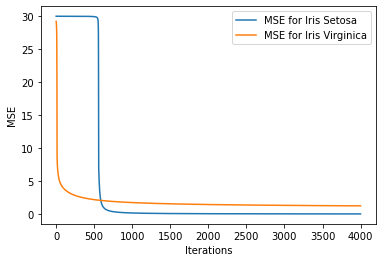

In [30]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [31]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9666666666666667

In [32]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  18   2
2.0         0   0  20


# Single feature

## petal_width

In [33]:

data = pd.read_csv('dataset/iris.data', header=None)
data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data['class'] = data['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data.drop(["sepal_width", "sepal_length", "petal_length"], axis=1, inplace=True)
data.head()

,petal_width,class
0,0.2,0
1,0.2,0
2,0.2,0
3,0.2,0
4,0.2,0


In [34]:
data_np = data.to_numpy()
training, test = data_np[:30, :], data_np[30:50, :]
training, test = np.append(training, data_np[50:80, :], axis=0), np.append(test, data_np[80:100, :], axis=0)
training, test = np.append(training, data_np[100:130, :], axis=0), np.append(test, data_np[130:, :], axis=0)
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90, 1), (90,), (60, 1), (60,))

In [35]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 0.2],
        [1. , 0.2],
        [1. , 0.2]]),
 array([[1. , 0.2],
        [1. , 0.4],
        [1. , 0.1]]))

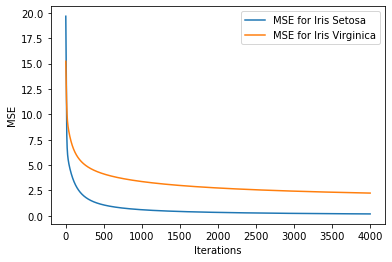

In [36]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [37]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9666666666666667

In [38]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  20   0
2.0         0   2  18


## petal_length

In [39]:
data = pd.read_csv('dataset/iris.data', header=None)
data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data['class'] = data['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data.drop(["sepal_width", "sepal_length", "petal_width"], axis=1, inplace=True)
data.head()

,petal_length,class
0,1.4,0
1,1.4,0
2,1.3,0
3,1.5,0
4,1.4,0


In [40]:
data_np = data.to_numpy()
training, test = data_np[:30, :], data_np[30:50, :]
training, test = np.append(training, data_np[50:80, :], axis=0), np.append(test, data_np[80:100, :], axis=0)
training, test = np.append(training, data_np[100:130, :], axis=0), np.append(test, data_np[130:, :], axis=0)
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90, 1), (90,), (60, 1), (60,))

In [41]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 1.4],
        [1. , 1.4],
        [1. , 1.3]]),
 array([[1. , 1.6],
        [1. , 1.5],
        [1. , 1.5]]))

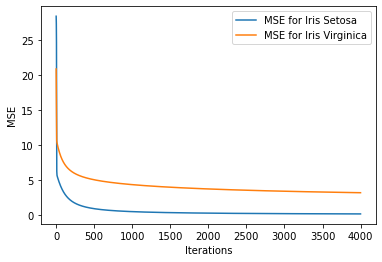

In [42]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [43]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9666666666666667

In [44]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  19   1
2.0         0   1  19


# Two features
In this section petal_width and petal_length is used as the features

In [45]:
data = pd.read_csv('dataset/iris.data', header=None)
data.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
data['class'] = data['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
data.drop(["sepal_width", "sepal_length"], axis=1, inplace=True)
data.head()

,petal_length,petal_width,class
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


In [46]:
data_np = data.to_numpy()
training, test = data_np[:30, :], data_np[30:50, :]
training, test = np.append(training, data_np[50:80, :], axis=0), np.append(test, data_np[80:100, :], axis=0)
training, test = np.append(training, data_np[100:130, :], axis=0), np.append(test, data_np[130:, :], axis=0)
X_train, y_train = training[:, :-1], training[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90, 2), (90,), (60, 2), (60,))

In [47]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_train[:3], X_test[:3]

(array([[1. , 1.4, 0.2],
        [1. , 1.4, 0.2],
        [1. , 1.3, 0.2]]),
 array([[1. , 1.6, 0.2],
        [1. , 1.5, 0.4],
        [1. , 1.5, 0.1]]))

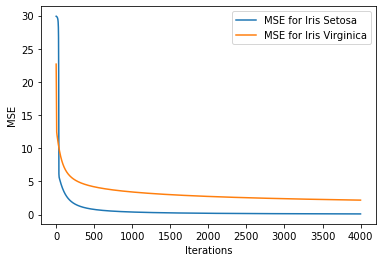

In [48]:
classifier_setosa, classifier_viriginica = multi_class_linear_classifier(learning_rate=0.005, n_iters=4000)

In [49]:
multi_class_linear_classifier_test(classifier_setosa, classifier_viriginica, X_test, y_test)

0.9666666666666667

In [50]:
pred = multi_class_linear_classifier_predict(classifier_setosa, classifier_viriginica, X_test)
confusion_matrix(y_test, pred)

Predicted   0   1   2
Actual               
0.0        20   0   0
1.0         0  20   0
2.0         0   2  18
